In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as splin
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf
import _pickle as pickle
from sklearn.manifold import TSNE
import scipy.linalg as splin

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plotProjections(projections, clist, gridsize=2):
    xsize = 8
    ysize = 8
    figs, axs = plt.subplots(nrows = gridsize, ncols = gridsize, figsize=(4*xsize,4*ysize))
    for row in range(gridsize):
        for col in range(gridsize):
            if col >= row:
                if col == row:
                    sortIndex = row+2
                else:
                    sortIndex = row+1
                py = projections[:,row]
                px = projections[:,col+1]
                sorting = projections[:,sortIndex].argsort()
                
                CLIST = np.array(clist)[sorting]
                PX = px[sorting]
                PY = py[sorting]
                
                rangeX = PX.max() - PX.min()
                centerX = (PX.max() + PX.min())/2.0
                rangeY = PY.max() - PY.min()
                centerY = (PY.max() + PY.min())/2.0
                axesDist = 0.6*max(rangeX,rangeY)
                
                sc1 = axs[row,col].scatter(PX,PY,alpha=0.7,c=CLIST)
                
                subTitle = str(row+1) + ' vs. ' + str(col+2)
                
                axs[row,col].set_title(subTitle)
                axs[row,col].set_xlim([centerX - axesDist, centerX + axesDist])
                axs[row,col].set_ylim([centerY - axesDist, centerY + axesDist])
                axs[row,col].ticklabel_format(style='sci', scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil)
        pick.dump(thing)
        pick.clear_memo()
        
def openThing(file,py2 = False):
    if py2:
        with open(file,'rb') as fil:
            u = pickle._Unpickler(fil)
            u.encoding = 'latin1'
            thing = u.load()
    else:
        with open(file,'rb') as fil:
            thing = pickle.load(fil)
    return thing


MNIST plots

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x,[-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1)+b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7*7*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)

W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

y_conv = tf.matmul(h_fc1_drop,W_fc2) + b_fc2

In [7]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    probs_estimators = y_conv.eval(feed_dict={x: mnist.test.images, keep_prob:1.0},session=sess)

step 0, training accuracy 0.18
step 100, training accuracy 0.84
step 200, training accuracy 0.9
step 300, training accuracy 0.94
step 400, training accuracy 0.98
step 500, training accuracy 0.98
step 600, training accuracy 0.98
step 700, training accuracy 0.9
step 800, training accuracy 0.98
step 900, training accuracy 0.98
step 1000, training accuracy 0.94
step 1100, training accuracy 1
step 1200, training accuracy 0.98
step 1300, training accuracy 0.96
step 1400, training accuracy 0.94
step 1500, training accuracy 1
step 1600, training accuracy 0.96
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.94
step 2200, training accuracy 0.96
step 2300, training accuracy 0.96
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 0.96
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 0.96
step 3000, trai

Plotting Data

In [8]:
probs = np.array([[np.exp(x)/sum([np.exp(y) for y in prob]) for x in prob] for prob in probs_estimators])

In [9]:
def findProj(data,eigs=4):
    data = np.array(data)
    DDT = np.log(np.dot(data,data.T))
    DDT_sums = np.array([sum(row)/len(data) for row in DDT])
    DDT_sum_sums = sum(DDT_sums)/len(data)
    DDT_PCA = np.array([[DDT[i][j] - DDT_sums[i] - DDT_sums[j] + DDT_sum_sums for i in range(len(data))] for j in range(len(data))])
    
    wR,vRt = splin.eigh(DDT_PCA,eigvals=(len(DDT)-1-eigs,len(DDT)-1))
    wI,vIt = splin.eigh(DDT_PCA,eigvals=(0,eigs))
    
    W = list(wR)
    W.extend(list(wI))
    W = np.array(W)
    sorting = abs(np.array(W)).argsort()[::-1]
    
    V = list(vRt.T)
    V.extend(list(vIt.T))
    V = np.array(V)
    
    W = W[sorting]
    V = V[sorting]
    
    imCol = []
    for i in range(len(W)):
        if W[i] < 0:
            imCol.append(i)
            
    proj = np.dot(V.T,np.diag(np.sqrt(np.abs(W))))
    
    return(proj,imCol)

In [10]:
proj,imCol = findProj(np.sqrt(probs),eigs=4)

In [16]:
saveThing(proj,'proj.pckl')
saveThing(probs,'probs.pckl')

In [21]:
colors = ['C'+str(i) for i in range(10)]
clist = []
labels = []
for label in mnist.test.labels:
    for e in range(10):
        if label[e] == 1:
            clist.append(colors[e])
            labels.append(e)
saveThing(labels,'labels.pckl')

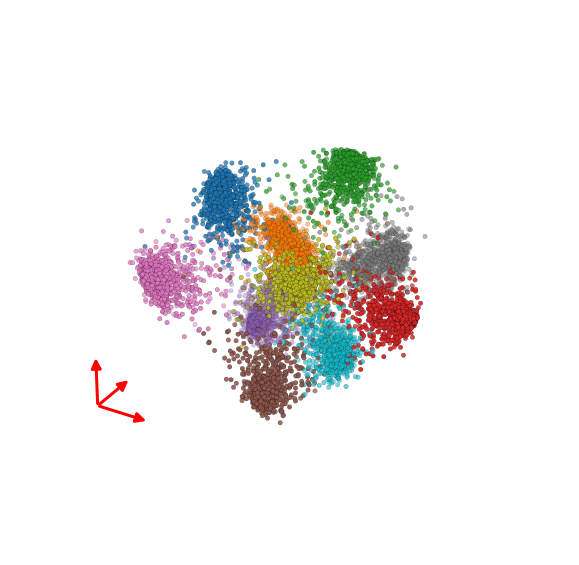

In [12]:
#3D plots
px = proj[:,0]
py = proj[:,1]
pz = proj[:,2]

mean_x = px.min()
mean_y = py.min()
mean_z = pz.min()

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0

dist = 0.5*max(Xdist,Ydist,Zdist)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
#ax.view_init(30,-60)

listTemp = [i for i in range(len(proj))]

ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2)

ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

arrowSize=2*dist/5

vects = [[mean_x+arrowSize,mean_y,mean_z],[mean_x,mean_y+arrowSize,mean_z],[mean_x,mean_y,mean_z+arrowSize]]

for v in vects:
    a = Arrow3D([mean_x,v[0]],[mean_y,v[1]],
                [mean_z,v[2]],mutation_scale=20,
                lw=3,arrowstyle="-|>",color="r")
    ax.add_artist(a)
ax.set_axis_off()

In [156]:
X = -2*np.log(np.dot(probs,probs.T))

In [157]:
X_embedded=TSNE(n_components=3).fit_transform(X)

In [50]:
sampleDigits = mnist.test.images[[3,2,1,30,19,15,21,0,61,16]]

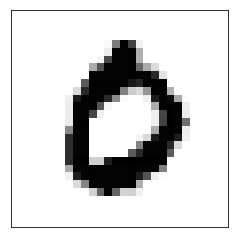

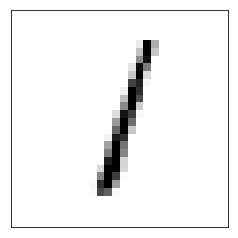

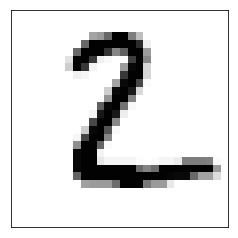

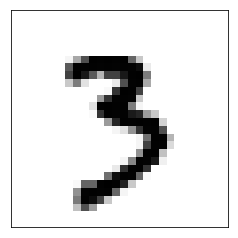

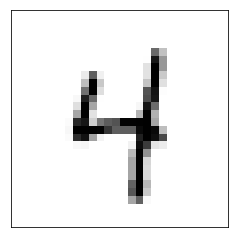

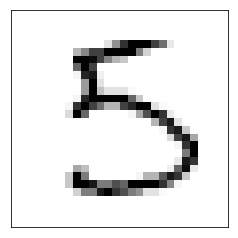

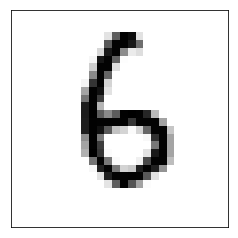

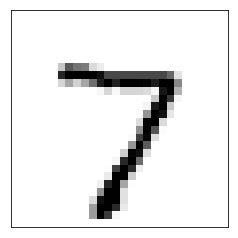

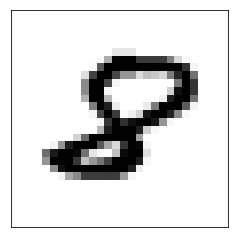

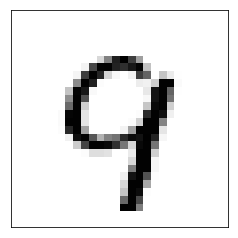

In [58]:
for image in sampleDigits:
    plt.imshow([image[28*i:28*(i+1)] for i in range(28)],cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [52]:
saveThing(sampleDigits,'sampleDigits.pckl')

In [37]:
probs = openThing('probs.pckl')
labels = openThing('labels.pckl')

In [73]:
def klDiv(p1,p2):
    return sum(p1*np.log(p1)-p1*np.log(p2) + p2*np.log(p2)-p2*np.log(p1))

In [26]:
distances = [[-8*np.log(np.dot(np.sqrt(p1),np.sqrt(p2))) for p1 in probs] for p2 in probs]

In [57]:
distances = abs(np.array(distances))

In [60]:
X_embedded = TSNE(n_components=3).fit_transform(distances)

In [76]:
klDistances = [[klDiv(p1,p2) for p1 in probs] for p2 in probs]

In [77]:
X_kl = TSNE(n_components=3).fit_transform(klDistances)

In [80]:
X_kl2D = TSNE(n_components=2).fit_transform(klDistances)

In [62]:
X_euclid = TSNE(n_components=3,init='pca').fit_transform(probs)

In [ ]:
#3D plots
proj = X_kl2D

px = proj[:,0]
py = proj[:,1]
pz = proj[:,2]

mean_x = px.min()
mean_y = py.min()
mean_z = pz.min()

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0

dist = 0.5*max(Xdist,Ydist,Zdist)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
#ax.view_init(30,-60)

ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2)

ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

In [82]:
saveThing(X_kl2D,'tsneKL2D.pckl')

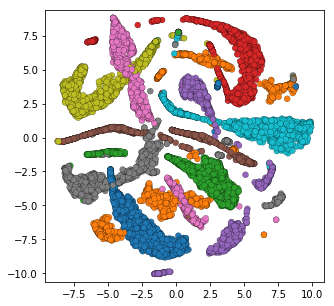

In [89]:
plt.figure(figsize=(5,5))
plt.scatter(X_kl2D[:,0],X_kl2D[:,1],c=clist,edgecolor='black',linewidth=0.2)
plt.axis('equal')
plt.show()

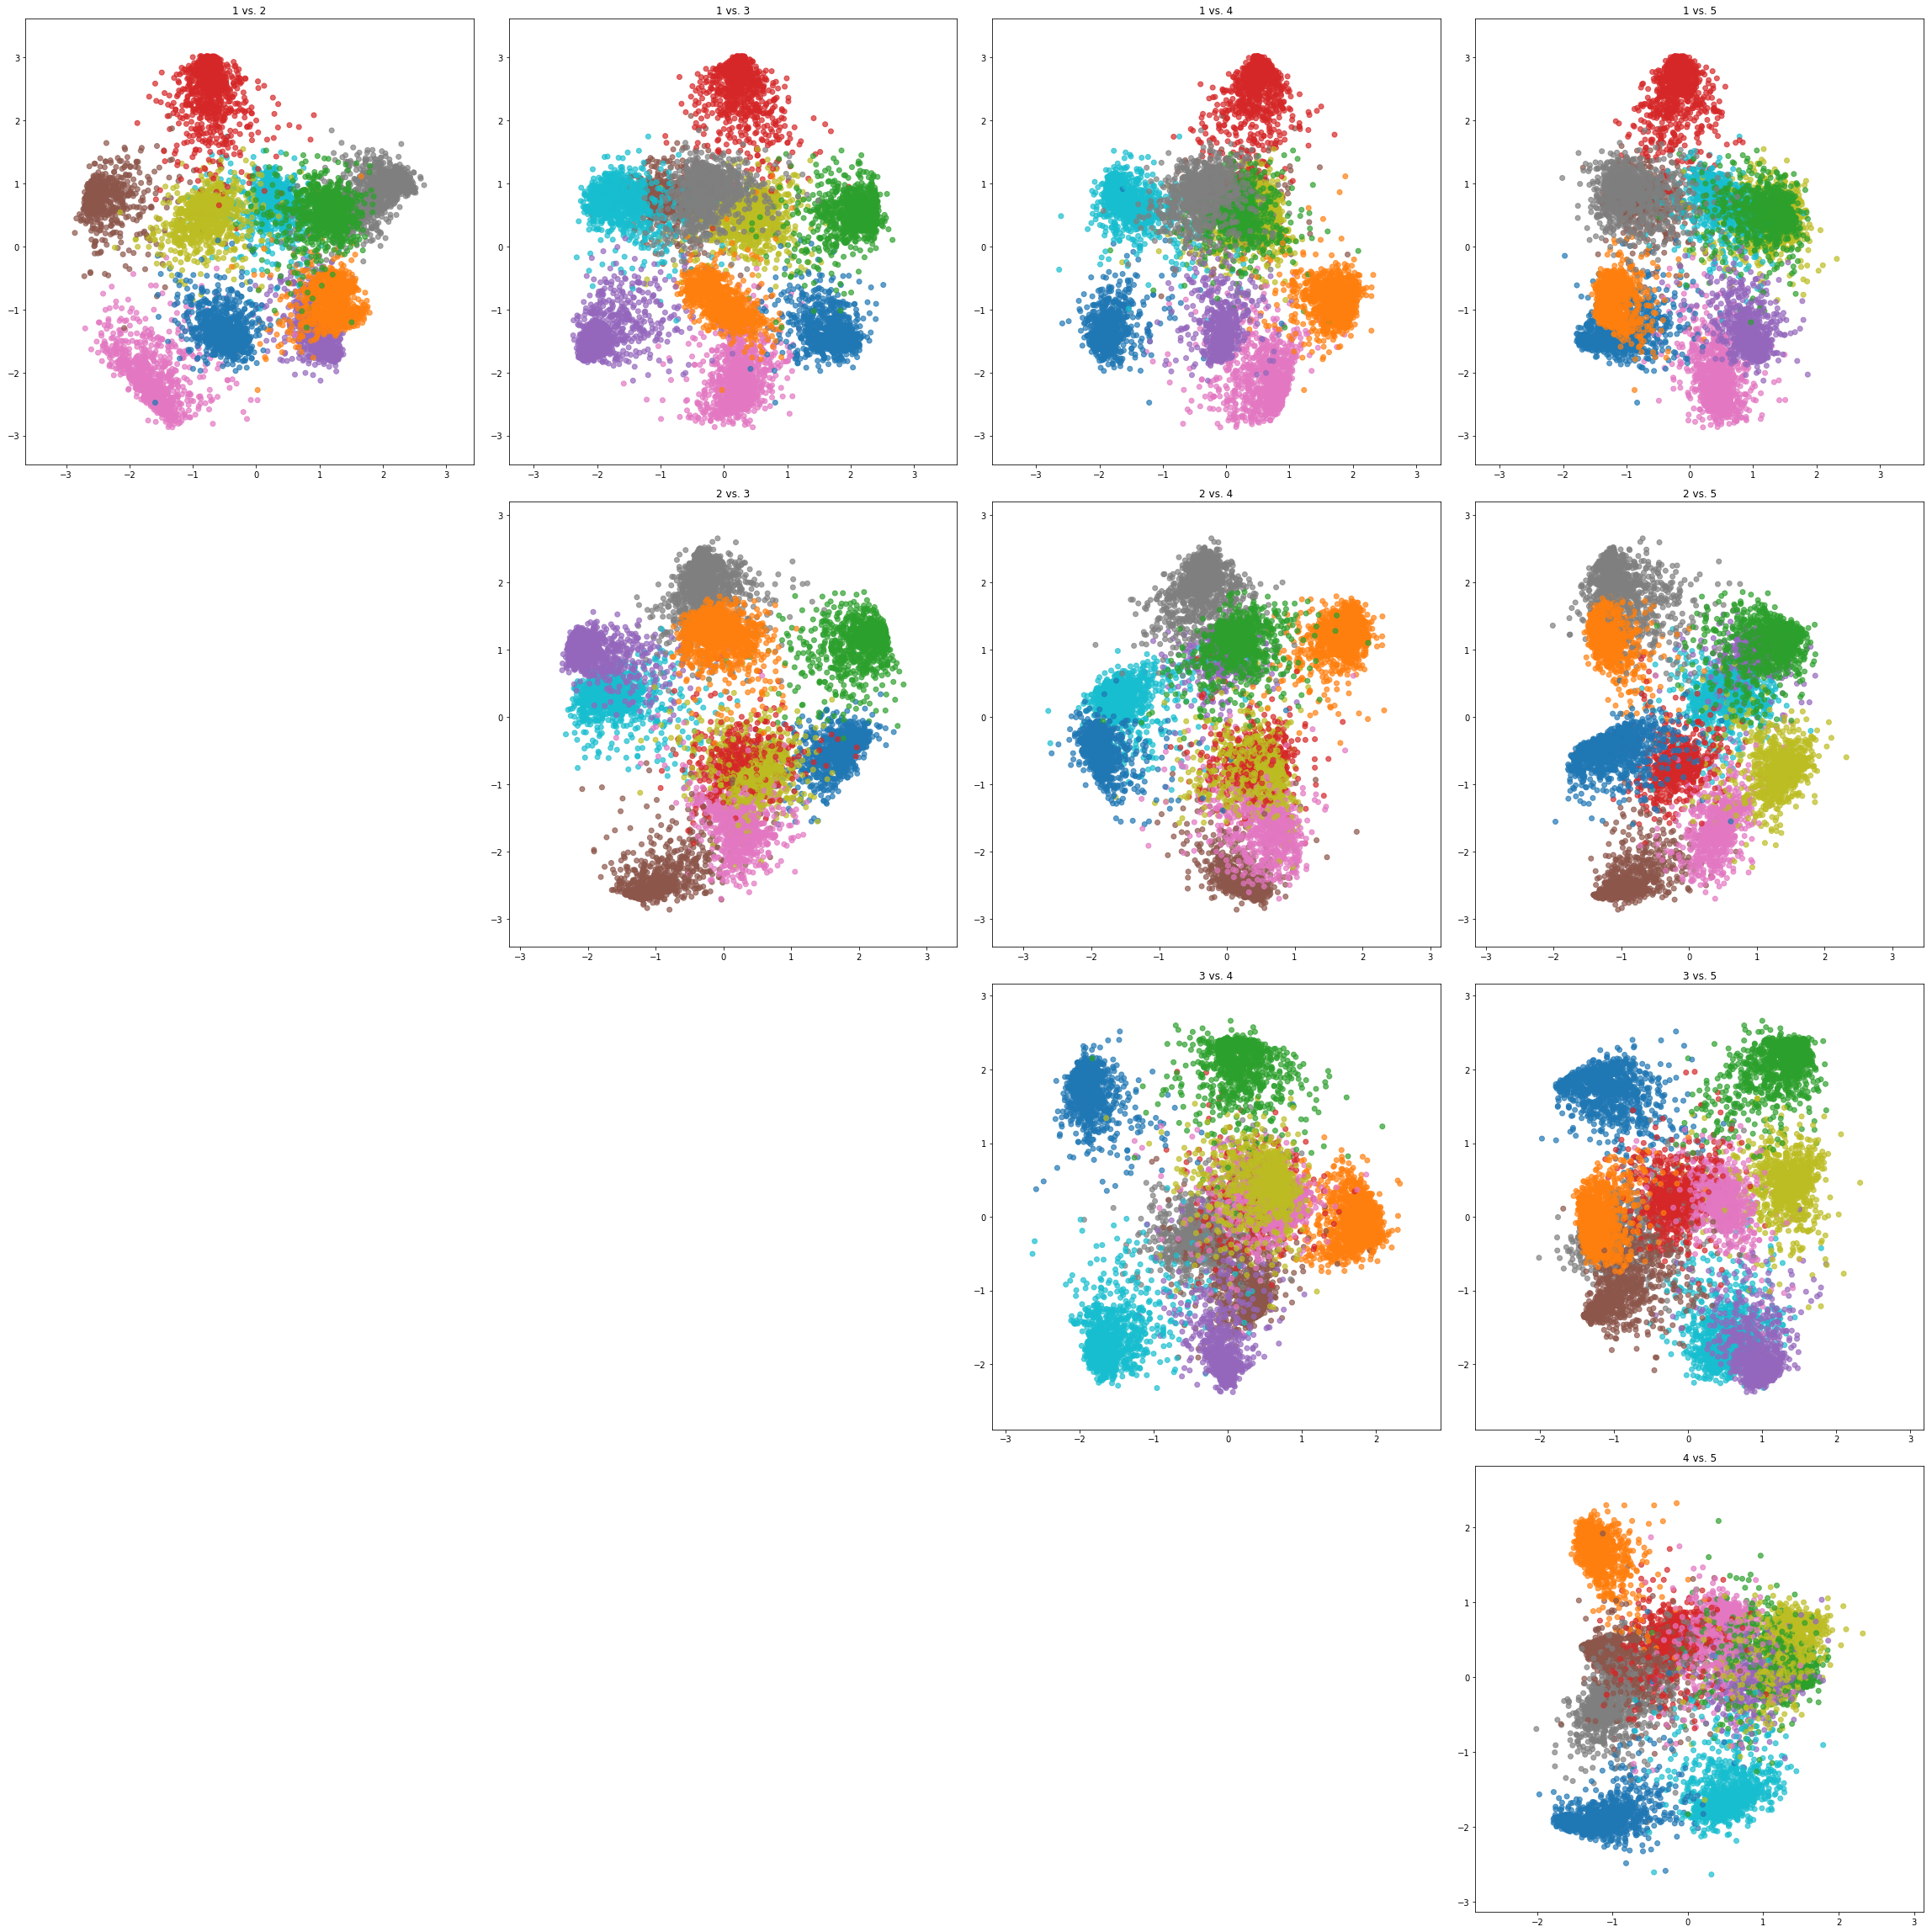

In [13]:
plotProjections(proj,clist,gridsize=4)